# Python Project : Delta Hedging of a Multi-Asset Portfolio

**Author:** Baptiste Sorel  
**Date:** September 2025  

---

## Project Description

This project aims to implement and analyze **pricing** and **risk management** techniques for options on multiple assets.  

Main objectives:  
- Implement the Black–Scholes framework for call and put options.  
- Compute **$\Delta$** and study their role in portfolio hedging.  
- Simulate correlated asset price paths using Geometric Brownian Motion.  
- Compare the performance of a **delta-hedged portfolio** versus an unhedged one.  
- Run Monte Carlo simulations to evaluate the efficiency of hedging strategies.  

In this project, we consider a portfolio consisting of a short position on 1 MSFT call, a long position on 3 MSFT puts, and a short position on 2 AAPL calls.
$\newline$ The position is hedged on a daily basis.
$\newline$ To simplify, we assume that there is no transactions or taxes.

Here are the assomptions made : 
$K_{MSFT}=\$500
\\ K_{AAPL}=\$230 
\\ T=1
\\ r=4\% \text{    (assumed constant)}
\\ q_{MSFT}=0.66\%    \text{   (annual dividend yield)}
\\ q_{AAPL} = 0.44\%    \text{   (annual dividend yield)}$

Importing libraries :

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

Import one year of data for MSFT and AAPL stocks

In [18]:
msft = yf.download("MSFT", start="2024-09-12", end="2025-09-13")
aapl= yf.download("AAPL", start="2024-09-12", end="2025-09-13")

/var/folders/8q/kj7m75296sv_5p5v_vh1dkw40000gn/T/ipykernel_15500/968577911.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft = yf.download("MSFT", start="2024-09-12", end="2025-09-13")
[*********************100%***********************]  1 of 1 completed
/var/folders/8q/kj7m75296sv_5p5v_vh1dkw40000gn/T/ipykernel_15500/968577911.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl= yf.download("AAPL", start="2024-09-12", end="2025-09-13")
[*********************100%***********************]  1 of 1 completed


The constants are defined as follows : 

In [19]:
S_MSFT_spot=msft.iloc[-1].iloc[0] #Microsoft on the 12/09/25
S_AAPL_spot=aapl.iloc[-1].iloc[0] #Apple on the 12/09/2025
q_MSFT=0.66/100 
q_AAPL=0.44/100
K_MSFT=500
K_AAPL=230
T=1
r=4/100
N=252 #Number of days in one year
mu_MSFT=r-q_MSFT
mu_AAPL=r-q_AAPL
days=[i for i in range(N)] #used to plot
w1=1 # nbr of MSFT calls
w2=3 # nbr of MSFT puts
w3=2 # nbr of AAPL calls

Estimation of the historic volatilities (also assumed as implied volatitiliees) and correlation between MSFT and AAPL : 

In [20]:
u=[0]*len(msft)
for i in range(1,len(msft)):
    u[i]=np.log(msft.iloc[i].iloc[1]/msft.iloc[i-1].iloc[0])
u=u[1:]
sigma_MSFT=np.std(u)*np.sqrt(N)

v=[0]*len(msft)
for i in range(1,len(aapl)):
    v[i]=np.log(aapl.iloc[i].iloc[1]/aapl.iloc[i-1].iloc[0])
v=v[1:]
sigma_AAPL=np.std(v)*np.sqrt(N)

cov=np.cov(u,v)[0,1]
rho=cov/(np.std(u)*np.std(v))

print(sigma_MSFT,rho)

0.224449077105502 0.4188630634529268


Implementation of the price of the two correlated underlyings, for $N$ days : 

In [21]:
def S_price_correlated(mu1,mu2,sigma1,sigma2,N,S_spot1,S_spot2,corr):
    S1,S2=[0]*N,[0]*N
    S1[0],S2[0]=S_spot1,S_spot2
    for i in range(1,N):
        z1=np.random.randn()
        z2=np.random.randn()
        eps1=z1
        eps2=corr*z1+np.sqrt(1-corr**2)*z2
        S1[i]=S1[i-1]*np.exp((mu1-0.5*sigma1**2)*1/N+sigma1*np.sqrt(1/N)*eps1)
        S2[i]=S2[i-1]*np.exp((mu2-0.5*sigma2**2)*1/N+sigma2*np.sqrt(1/N)*eps2)
    return S1,S2

We now compute the $\Delta$ of the portfolio. Since we have two. underlyings, we need to delta hedge our positions on the two assets :

In [22]:
def N_d1(K,r,sigma,N,S,q): # function that returns N(d_1) of an option
    L=[0]*N
    for i in range(N): 
        tau=(N-i)/N
        d1=(np.log(S[i]/K)+(r-q+sigma**2/2)*tau)/(sigma*np.sqrt(tau))
        L[i]=np.exp(-q*tau)*norm.cdf(d1)
    return L

def Delta_Portfolio(w1,w2,w3,S_MSFT,S_AAPL): #function that returns the delta of the position on MSFT and AAPL
    D1=[N_d1(K_MSFT,r,sigma_MSFT,N,S_MSFT,q_MSFT)[i] for i in range (len(N_d1(K_MSFT,r,sigma_MSFT,N,S_MSFT,q_MSFT)))] #Delta of a MSFT call
    D2=[N_d1(K_MSFT,r,sigma_MSFT,N,S_MSFT,q_MSFT)[i] -1 for i in range (len(N_d1(K_MSFT,r,sigma_MSFT,N,S_MSFT,q_MSFT)))] #Delta of a MSFT put
    D3=[N_d1(K_AAPL,r,sigma_AAPL,N,S_AAPL,q_AAPL)[i] for i in range (len(N_d1(K_AAPL,r,sigma_AAPL,N,S_AAPL,q_AAPL)))] #Delta of a AAPL call
     
    Delta_MSFT=[-D1[i]*w1+w2*D2[i] for i in range(len(N_d1(K_MSFT,r,sigma_MSFT,N,S_MSFT,q_MSFT)))]
    Delta_AAPL=[-D3[i]*w3 for i in range(len(N_d1(K_MSFT,r,sigma_MSFT,N,S_MSFT,q_MSFT)))]
    return (Delta_MSFT,Delta_AAPL)

We use Black-Scholes to compute the price of a call and a put : 

In [23]:
def c_price(N,S,sigma,q,K):
    c=[0]*N
    for i in range(N):
        tau=(N-i)/N
        d1=(np.log(S[i]/K)+(r-q+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
        c[i]=S[i]*np.exp(-q*tau)*norm.cdf(d1)-K*np.exp(-r*tau)*norm.cdf(d1-sigma*np.sqrt(tau))
    return c

def p_price(N,S,sigma,q,K):
    p=[0]*N
    for i in range(N):
        tau=(N-i)/N
        d1=(np.log(S[i]/K)+(r-q +0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
        d2=d1-sigma*np.sqrt(tau)
        p[i]=K*np.exp(-r*tau)*norm.cdf(-d2)-S[i]*np.exp(-q*tau)*norm.cdf(-d1)
    return p

To calculate the value of the hedged portfolio, we include the net gains or losses from transactions on the underlying assets required to rebalance it. These are computed and tracked in the cash account. 

The cash account is updated at each step to reflect rebalancing costs:

In [24]:
def cash_account_MSFT(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT):
    B=[0]*N
    B[0]=w1*c_MSFT[0]-(-Delta_MSFT[0]*S_MSFT[0])-w2*p_MSFT[0] #initially, we receive w1*c_MSFT[0] from shorting the call, we pay w2*p_MSFT[0] from the puts and we pay -(-Delta_MSFT[0]*S_MSFT[0]) of hedging
    for i in range(1,N):
        B[i]=B[i-1]*(1+r/N)+(Delta_MSFT[i]-Delta_MSFT[i-1])*S_MSFT[i] #previous amount of money grows at the risk-free-rate and we add the new shares needed to hedge the new position
    return B

def cash_account_AAPL(N,c_AAPL,Delta_AAPL,S_AAPL):
    B=[0]*N
    B[0]=-(-Delta_AAPL[0]*S_AAPL[0])+w3*c_AAPL[0]
    for i in range(1,N):
        B[i]=B[i-1]*(1+r/N)+(Delta_AAPL[i]-Delta_AAPL[i-1])*S_AAPL[i]
    return B

Now, we implemente the valuation of the portfolio for each day : 

In [25]:
def Portfolio(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT,c_AAPL,Delta_AAPL,S_AAPL,B_MSFT,B_AAPL):
    P=[0]*N
    P[0]=-w1*c_MSFT[0]-Delta_MSFT[0]*S_MSFT_spot+w2*p_MSFT[0]-w3*c_AAPL[0]-Delta_AAPL[0]*S_AAPL[0]+B_AAPL[0]+B_MSFT[0] #it actually gives P[0]=0 : no amount of money is needed to have the hedged position
    for i in range(1,N):
        P[i]=-w1*c_MSFT[i]-Delta_MSFT[i]*S_MSFT[i]+w2*p_MSFT[i]-w3*c_AAPL[i]-Delta_AAPL[i]*S_AAPL[i]+B_MSFT[i]+B_AAPL[i]
    return P

#### Let's see what it gives for a single simulation run :  

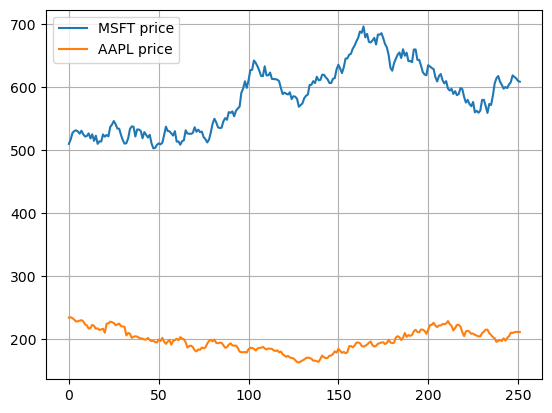

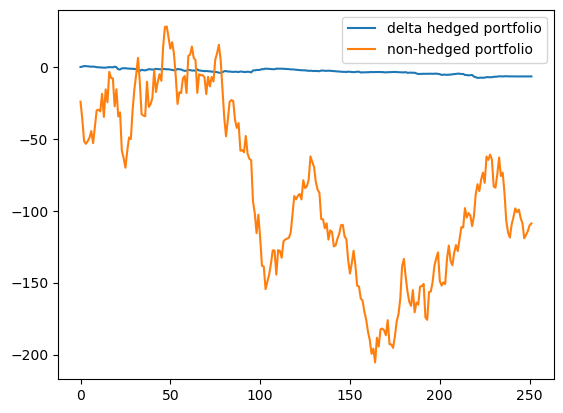

In [26]:
####### Compute the portfolios ######

S_MSFT_corr=S_price_correlated(mu_MSFT,mu_AAPL,sigma_MSFT,sigma_AAPL,N,S_MSFT_spot,S_AAPL_spot,rho)[0]
S_AAPL_corr=S_price_correlated(mu_MSFT,mu_AAPL,sigma_MSFT,sigma_AAPL,N,S_MSFT_spot,S_AAPL_spot,rho)[1]

D_MSFT,D_AAPL=Delta_Portfolio(w1,w2,w3,S_MSFT_corr,S_AAPL_corr)

call_MSFT=c_price(N,S_MSFT_corr,sigma_MSFT,q_MSFT,K_MSFT)
call_AAPL=c_price(N,S_AAPL_corr,sigma_AAPL,q_AAPL,K_AAPL)
put_MSFT=p_price(N,S_MSFT_corr,sigma_MSFT,q_MSFT,K_MSFT)

cash_MSFT=cash_account_MSFT(N,call_MSFT,D_MSFT,S_MSFT_corr,put_MSFT)
cash_AAPL=cash_account_AAPL(N,call_AAPL,D_AAPL,S_AAPL_corr)

Port_hedged=Portfolio(N,call_MSFT,D_MSFT,S_MSFT_corr,put_MSFT,call_AAPL,D_AAPL,S_AAPL_corr,cash_MSFT,cash_AAPL)
Port_nonhedged=[-w1*call_MSFT[i] + w2*put_MSFT[i] -w3*call_AAPL[i] for i in range(len(call_AAPL))] #To compare, we create a non-hedged portfolio


######### PLOT #####################

def plot_S(S1,S2):
    plt.grid()
    plt.plot(days,S1,label="MSFT price")
    plt.plot(days,S2,label="AAPL price")
    plt.legend()
    plt.show()
    
def plot_test(P1,P2):
    plt.plot(days,P1,label="delta hedged portfolio")
    plt.plot(days,P2,label="non-hedged portfolio")
    plt.legend()
    plt.show()
    
plot_S(S_MSFT_corr,S_AAPL_corr)
plot_test(Port_hedged,Port_nonhedged)

We can observe that the non-hedged portfolio is highly volatile, and gives uncertain profit, as we could guessed.
$\newline$ On the other hand, the hedged portfolio is closed to be constantly equal to 0. That's indeed what we should expect from a delta-hedged portfolio.

#### Let’s now look at the outcomes of multiple simulations to compute the mean and standard deviation :

In [29]:
def Simu_Monte_Carlo(n):
    PNL_hedge,PNL_nohedge=[0]*n,[0]*n
    for i in range (n):
        S_MSFT=S_price_correlated(mu_MSFT,mu_AAPL,sigma_MSFT,sigma_AAPL,N,S_MSFT_spot,S_AAPL_spot,rho)[0]
        S_AAPL=S_price_correlated(mu_MSFT,mu_AAPL,sigma_MSFT,sigma_AAPL,N,S_MSFT_spot,S_AAPL_spot,rho)[1]
        Delta_MSFT,Delta_AAPL = Delta_Portfolio(w1,w2,w3,S_MSFT,S_AAPL)
        c_MSFT=c_price(N,S_MSFT,sigma_MSFT,q_MSFT,K_MSFT)
        p_MSFT=p_price(N,S_MSFT,sigma_MSFT,q_MSFT,K_MSFT)
        c_AAPL=c_price(N,S_AAPL,sigma_AAPL,q_AAPL,K_AAPL)
        B_MSFT=cash_account_MSFT(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT)
        B_AAPL=cash_account_AAPL(N,c_AAPL,Delta_AAPL,S_AAPL)
        
        P_hedged=Portfolio(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT,c_AAPL,Delta_AAPL,S_AAPL,B_MSFT,B_AAPL)
        
        P_nonhedged=[-w1*c_MSFT[j] + w2*p_MSFT[j] -w3*c_AAPL[j] for j in range(len(c_AAPL))]
        
        PNL_nohedge[i]=P_nonhedged[N-1]-P_nonhedged[0]
        PNL_hedge[i]=P_hedged[N-1]-P_hedged[0]

    print("Profit moyen sans hedge = "+str(np.mean(PNL_nohedge))+"  ecart-type = "+str(np.std(PNL_nohedge)))
    print("Profit moyen avec hedge = "+str(np.mean(PNL_hedge))+"  ecart-type = "+str(np.std(PNL_hedge)))

In [31]:
Simu_Monte_Carlo(50)

Profit moyen sans hedge = -17.338748882425254  ecart-type = 214.5245392072407
Profit moyen avec hedge = -7.458492510574795  ecart-type = 6.980155576034383


For example, for $n=50$ , I got the following result : 
$\newline \textit{"Average profit without hedge = -17.338748882425254  standard deviation = 214.5245392072407"}$
$\textit{"Average profit with hedge = -7.458492510574795  standard deviation = 6.980155576034383"}$
$\newline$ Even though the means seem to be close, we can see that the P&L from the non-hedged-portfolio is highly uncertain.
The P&L from the hedged portfolio is much more certain, and close to zero, but not exactly.
$\newline$ In an ideal Black-Scholes model with continuous delta hedging, the P&L of a perfectly hedged portfolio should be zero, as the strategy replicates the option's value and eliminates directional risk. However, in our discrete Monte Carlo simulation with \( N = 252 \) steps, the P&L is close to 0 but not exactly 0 due to the following reasons:
- Discrete Rebalancing: Hedging occurs at discrete intervals rather than continuously, leading to small errors from unhedged price movements between steps (known as gamma risk).
- Estimation Errors: The deltas and option prices are approximated using historical volatility and discrete calculations, which may deviate slightly from true market values.
- Randomness: Each simulation path is stochastic, and the finite number of simulations (\( n = 50 \)) introduces statistical noise.

These factors cause a small residual P&L, but the hedging significantly reduces volatility compared to the unhedged case.